 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. 
Then you will tune it using grid search and Bayesian optimization, 
potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see 
if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

In [4]:
# Installs the necessary Python and system libraries
! pip install easypip
from easypip import easyimport, easyinstall, is_notebook

! pip install swig
! pip install box2d-py
! pip install bbrl_gymnasium
! pip install tensorboard
! pip install moviepy
! pip install optuna
! pip install mazemdp

import sys
import os
import numpy as np
from pathlib import Path
from typing import List, Tuple

if is_notebook() and get_ipython().__class__.__module__ != "google.colab._shell":
   from tqdm.autonotebook import tqdm
else:
   from tqdm.auto import tqdm


import matplotlib.pyplot as plt

if not is_notebook():
    print("Not displaying video (hidden since not in a notebook)", file=sys.stderr)
    def video_display(*args, **kwargs):
        pass
    def display(*args, **kwargs):
        print(*args, **kwargs) 

testing_mode = os.environ.get("TESTING_MODE", None) == "ON"

import gymnasium as gym

! pip install bbrl_utils

easyimport("bbrl_utils").setup(maze_mdp=True)

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

# matplotlib.use("TkAgg")

import seaborn as sns
sns.set_theme()
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

/var/folders/t_/frzm_2tj29v28m53gb74jjj00000gn/T/ipykernel_58143/2309687237.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Matplotlib backend: module://matplotlib_inline.backend_inline


# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Code the naive actor-critic algorithm as specified above.

A good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

We provide some code structure below. Following this structure is not mandatory, but you should at least ensure that the signature of the ```actor_critic_v(...)``` function is respected so that the code of the next exercises can be run appropriately.

In [5]:
def renormalize(
    mdp: MazeMDPEnv,
    policy: np.array,
    state: np.array,
) -> None:
    """
    Renormalize the probability of actions so that the sum of probabilities over actions is always 1.
    We made sure in the calling function that the probabilities of action never get negative when they are decreased.
    :param mdp: the mdp the agent is working in (to get the number of actions)
    :param policy: the current policy, before normalization 
    :param state: the state where the actions need to be renormalized
    :return: nothing
    """
    # Get sum of probabilities for all actions in the given state
    sum_probs = np.sum(policy[state, :])
    
    # Normalize each action probability by dividing by the sum
    # This ensures all probabilities sum to 1
    if sum_probs > 0:  # Avoid division by zero
        policy[state, :] = policy[state, :] / sum_probs
    else:
        # If all probabilities are 0, set to uniform distribution
        policy[state, :] = 1.0 / mdp.action_space.n

In [6]:
def perform_episode(
    mdp: MazeMDPEnv,
    policy: np.array,
    v: np.array,
    alpha_critic: float,
    alpha_actor: float,
    render: bool = True,
) -> int:
    """
    Perform an episode on the given mdp with the given policy
    :param mdp: the mdp the agent is working in
    :param policy: the current policy
    :param v: the current critic
    :param alpha_critic: the learning rate of the critic
    :param alpha_actor: the learning rate of the actor
    :return: the number of steps before it stops
    """
    # Draw the first state of the episode using a uniform distribution over all the states
    state, _ = mdp.reset(uniform=True)
    terminated = False
    truncated = False
    steps = 0

    # Initialize visualization if rendering is enabled
    if render:
        mdp.init_draw("Actor-Critic Training")

    while not (terminated or truncated):
        # Render current state with value function and policy if enabled
        if render:
            mdp.draw_v_pi(v, policy)
            
        # Sample action from current policy
        action = sample_categorical(policy[state])
        
        next_state, reward, terminated, truncated, _ = mdp.step(action)
        
        # Calculate TD error
        if terminated:
            delta = reward - v[state]
        else:
            delta = reward + mdp.gamma * v[next_state] - v[state]
            
    
        v[state] = v[state] + alpha_critic * delta # update the V values
        
        # Update actor (policy)
        temp_prob = policy[state, action] + alpha_actor * delta
        policy[state, action] = max(1e-8, temp_prob)
        
        # Renormalize policy
        renormalize(mdp, policy, state)
        
        # Move to next state
        state = next_state
        steps += 1

    # Final render of the episode if enabled
    if render:
        mdp.draw_v_pi(v, policy)

    return steps

Here comes the main actor-critic function. It should take the shown parameters as input and output a list of value norms and a list of number of steps,
corresponding to the evolution of these quantities through learning

In [7]:
def actor_critic_v(
    mdp: MazeMDPEnv,
    nb_episodes: int,
    alpha_critic: float,
    alpha_actor: float,
    render: bool = True,
) -> np.array:
    """
    Perform actor-critic training over a number of episodes
    :param mdp: the mdp the agent is working in (to get the number of actions to initialize the policy)
    :param nb_episodes: the number of episodes
    :param alpha_critic: the learning rate of the critic
    :param alpha_actor: the learning rate of the actor
    :param render: whether training should be rendered
    :return: a list of norm of V values and a list of number of steps of episodes
    """
    
    policy = np.ones((mdp.observation_space.n, mdp.action_space.n)) / mdp.action_space.n
    v = np.zeros(mdp.observation_space.n)
    
    # Lists to store metrics
    v_norm_list = []
    steps_list = []
    
    for episode in range(nb_episodes):
        # Perform one episode and get number of steps
        steps = perform_episode(
            mdp=mdp,
            policy=policy,
            v=v,
            alpha_critic=alpha_critic,
            alpha_actor=alpha_actor,
            render=render
        )
        
        # Store metrics
        v_norm_list.append(np.linalg.norm(v)) # the v is updated as follows v[state] = v[state] + alpha_critic * delta on the function perform_episode
        steps_list.append(steps)
        
    return v_norm_list, steps_list

## Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.
Make sure that your figure complies with [The figure checklist](https://master-dac.isir.upmc.fr/The_figure_checklist.pdf).

In [37]:

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import os
from omegaconf import OmegaConf

from datetime import datetime

def plot_steps(cfg):
    """
    Plot the evolution of steps across episodes for multiple runs
    :param nb_repeats: number of times to repeat the experiment for statistics
    """
    # Store results from multiple runs
    all_steps = []
    all_v_norms = []

    # Details that will be shown on the plot (and on the pdf if saving option is enabled)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    param_text = (
        f"Parameters:\n"
        f"Episodes: {cfg.nb_episodes}\n"
        f"Repeats: {cfg.nb_repeats}\n"
        f"α_critic: {cfg.alpha_critic}\n"
        f"α_actor: {cfg.alpha_actor}\n"
        f"Maze size: {cfg.mdp.width}x{cfg.mdp.height}\n"
        f"Wall ratio: {cfg.mdp.ratio}"
    )
    # ================================
    

    os.makedirs(cfg.log_dir, exist_ok=True) # in order to save the logs
    os.makedirs(cfg.video_dir, exist_ok=True)
    

    for _ in range(cfg.nb_repeats): # in order to receive the statistics, we run the actor_critic_v algorithm multiple times

        print(f"Run {_ + 1} out of {cfg.nb_repeats}")

        
        env_run = gym.make( # we ar erunning the algorithm for a new environment every time. This will give as a comparion marge around the evolution line of steps for the differen tnumber of episodes
            "MazeMDP-v0",
            kwargs={"width": cfg.mdp.width, "height": cfg.mdp.height, "ratio": cfg.mdp.ratio},
            render_mode="human" if cfg.render else None
        ).unwrapped


        # Initialize the environment
        env_run.reset()

        if cfg.render: # we will design if this is the case
            env_run.init_draw("Actor-Critic Training")

        
        v_norm_list, steps_list = actor_critic_v(
            mdp=env_run,
            nb_episodes=cfg.nb_episodes,
            alpha_critic=cfg.alpha_critic,
            alpha_actor=cfg.alpha_actor,
            render=cfg.render,  # render=True to visualize the maze or False to run it faster
        )
        all_steps.append(steps_list)
        all_v_norms.append(v_norm_list)

        env_run.close()
    
    # We combine all results into a single array for easier processing and visualization
    all_steps = np.array(all_steps) 
    all_v_norms = np.array(all_v_norms)

    episodes = np.arange(cfg.nb_episodes)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)
    mean_v_norms = np.mean(all_v_norms, axis=0)
    std_v_norms = np.std(all_v_norms, axis=0)
    
    # Plot learning curves (always)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    plt.close('all')

    # Add title and parameters at the top
    fig = plt.figure(figsize=(12, 14))
    gs = plt.GridSpec(3, 1, height_ratios=[0.2, 1, 1])
    fig.suptitle(f'Actor-Critic Learning Progress - {timestamp}', fontsize=12, y=0.98)
    param_ax = fig.add_subplot(gs[0])
    param_ax.axis('off')
    param_ax.text(0.5, 0.5, param_text, 
                 ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                 fontfamily='monospace')
    
    # Steps plot
    ax1 = fig.add_subplot(gs[1])
    ax1.plot(episodes, mean_steps, label='Mean steps', color='blue')
    ax1.fill_between(episodes, 
                    mean_steps - std_steps, 
                    mean_steps + std_steps, 
                    alpha=0.2, 
                    color='blue')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Number of steps')
    ax1.set_title('Learning Progress: Steps per Episode')
    ax1.grid(True)
    ax1.legend()
    
    # V values norms plot
    ax2 = fig.add_subplot(gs[2])
    ax2.plot(episodes, mean_v_norms, label='Mean V norm', color='red')
    ax2.fill_between(episodes, 
                    mean_v_norms - std_v_norms, 
                    mean_v_norms + std_v_norms, 
                    alpha=0.2, 
                    color='red')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Value Function Norm')
    ax2.set_title('Learning Progress: Value Function Norm')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    
    # Saving in PDF format
    if cfg.save_curves:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f'learning_curves_{timestamp}.pdf'
        plt.savefig(os.path.join(cfg.log_dir, filename), bbox_inches='tight', 
                   dpi=300)
        print(f"Plot saved as: {filename}")
    
    plt.show()  # Always show the plots, even if saving is set to False
    plt.close()

    return np.mean(mean_v_norms)

# plot_steps(nb_repeats=2, nb_episodes=1000, alpha_critic=0.1, alpha_actor=0.1, render_training=True)

def plot_heatmap(cfg):
    """
    Create and save heatmap showing performance across different learning rates
    """
    # Define range of alpha values to test (using regular Python floats)
    alpha_values = [float(x) for x in np.linspace(0.01, 1.0, 10)]
    performance_matrix = np.zeros((len(alpha_values), len(alpha_values)))
    
    # Store original alpha values
    original_alpha_critic = float(cfg.alpha_critic)
    original_alpha_actor = float(cfg.alpha_actor)
    
    # Create environment once
    env = make_mdp(cfg)
    
    # Run experiments for different alpha combinations
    for i, alpha_critic in enumerate(alpha_values):
        for j, alpha_actor in enumerate(alpha_values):
            print(f"Testing α_critic={alpha_critic:.2f}, α_actor={alpha_actor:.2f}")
            
            # Run multiple episodes and store average performance
            all_steps = []
            for _ in range(3):  # Reduced number of repeats for efficiency
                v_norm_list, steps_list = actor_critic_v(
                    mdp=env,
                    nb_episodes=cfg.nb_episodes,
                    alpha_critic=float(alpha_critic),  # Convert to Python float
                    alpha_actor=float(alpha_actor),    # Convert to Python float
                    render=False
                )
                all_steps.append(np.mean(steps_list))
            
            # Store average performance
            performance_matrix[i, j] = np.mean(all_steps)
    
    # Create heatmap
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    plt.figure(figsize=(10, 8))
    
    # Plot heatmap
    sns.heatmap(performance_matrix, 
                xticklabels=np.round(alpha_values, 2),
                yticklabels=np.round(alpha_values, 2),
                cmap="coolwarm",
                annot=True,
                fmt='.1f')
    
    plt.title(f'Actor-Critic Performance\nAverage Steps per Episode\n{timestamp}')
    plt.xlabel('Alpha Actor (α_actor)')
    plt.ylabel('Alpha Critic (α_critic)')
    
    # Add parameter text
    param_text = (
        f"Parameters:\n"
        f"Episodes: {cfg.nb_episodes}\n"
        f"Maze size: {cfg.mdp.width}x{cfg.mdp.height}\n"
        f"Wall ratio: {cfg.mdp.ratio}"
    )
    plt.figtext(1.02, 0.5, param_text,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                fontfamily='monospace')
    
    plt.tight_layout()
    
    # Save if enabled
    if cfg.save_heatmap:
        filename = f'heatmap_{timestamp}.pdf'
        plt.savefig(os.path.join(cfg.log_dir, filename),
                   bbox_inches='tight',
                   dpi=300)
        print(f"Heatmap saved as: {filename}")
    
    plt.close()

## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [39]:
ac_params = {
    "save_curves": True,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array", # "human",
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 1000,
    "render": False, # True if we it go faster
    "nb_repeats": 50,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

## Test your code

The code for testing what you did so far is provided below.

Run 1 out of 50
Run 2 out of 50
Run 3 out of 50
Run 4 out of 50
Run 5 out of 50
Run 6 out of 50
Run 7 out of 50
Run 8 out of 50
Run 9 out of 50
Run 10 out of 50
Run 11 out of 50
Run 12 out of 50
Run 13 out of 50
Run 14 out of 50
Run 15 out of 50
Run 16 out of 50
Run 17 out of 50
Run 18 out of 50
Run 19 out of 50
Run 20 out of 50
Run 21 out of 50
Run 22 out of 50
Run 23 out of 50
Run 24 out of 50
Run 25 out of 50
Run 26 out of 50
Run 27 out of 50
Run 28 out of 50
Run 29 out of 50
Run 30 out of 50
Run 31 out of 50
Run 32 out of 50
Run 33 out of 50
Run 34 out of 50
Run 35 out of 50
Run 36 out of 50
Run 37 out of 50
Run 38 out of 50
Run 39 out of 50
Run 40 out of 50
Run 41 out of 50
Run 42 out of 50
Run 43 out of 50
Run 44 out of 50
Run 45 out of 50
Run 46 out of 50
Run 47 out of 50
Run 48 out of 50
Run 49 out of 50
Run 50 out of 50
Plot saved as: learning_curves_2025-02-10_00-53-22.pdf


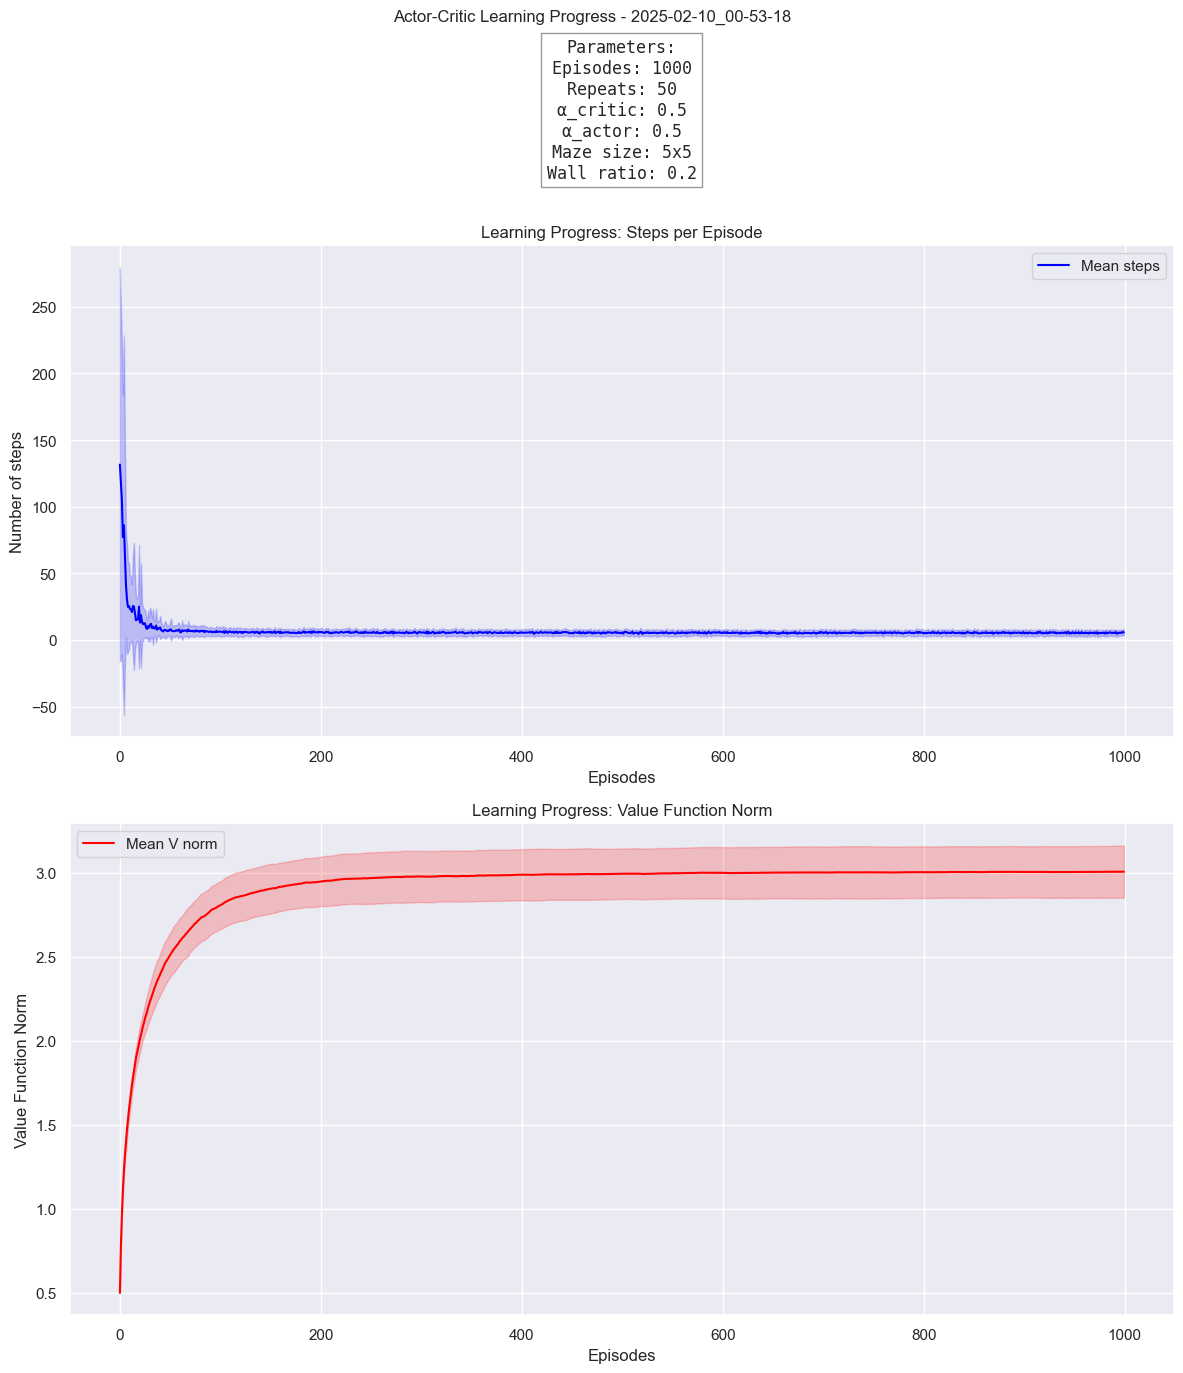


Now running heatmap plot...

Testing α_critic=0.01, α_actor=0.01


/Users/vasilisskarleas/Library/Mobile Documents/com~apple~CloudDocs/Documents/University Sorbonne/4th year/S8/Reinforcement learning/env-reinforcement-learning/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.gamma to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gamma` for environment variables or `env.get_wrapper_attr('gamma')` that will search the reminding wrappers.
  logger.warn(


Testing α_critic=0.01, α_actor=0.12
Testing α_critic=0.01, α_actor=0.23
Testing α_critic=0.01, α_actor=0.34
Testing α_critic=0.01, α_actor=0.45
Testing α_critic=0.01, α_actor=0.56
Testing α_critic=0.01, α_actor=0.67
Testing α_critic=0.01, α_actor=0.78
Testing α_critic=0.01, α_actor=0.89
Testing α_critic=0.01, α_actor=1.00
Testing α_critic=0.12, α_actor=0.01
Testing α_critic=0.12, α_actor=0.12
Testing α_critic=0.12, α_actor=0.23
Testing α_critic=0.12, α_actor=0.34
Testing α_critic=0.12, α_actor=0.45
Testing α_critic=0.12, α_actor=0.56
Testing α_critic=0.12, α_actor=0.67
Testing α_critic=0.12, α_actor=0.78
Testing α_critic=0.12, α_actor=0.89
Testing α_critic=0.12, α_actor=1.00
Testing α_critic=0.23, α_actor=0.01
Testing α_critic=0.23, α_actor=0.12
Testing α_critic=0.23, α_actor=0.23
Testing α_critic=0.23, α_actor=0.34
Testing α_critic=0.23, α_actor=0.45
Testing α_critic=0.23, α_actor=0.56
Testing α_critic=0.23, α_actor=0.67
Testing α_critic=0.23, α_actor=0.78
Testing α_critic=0.23, α_act

In [40]:
def make_mdp(cfg):
    mdp = gym.make(cfg.mdp.name, kwargs={"width": cfg.mdp.width, "height": cfg.mdp.height, "ratio": cfg.mdp.ratio}, render_mode=cfg.mdp.render_mode)
    mdp.reset()
    return mdp

cfg=OmegaConf.create(ac_params)
mdp = make_mdp(cfg) # the mdp is made once and for all, this is an ugly global variable
plot_steps(cfg)

# If you want to test the heatmap, uncomment the following line
if cfg.save_heatmap:
    print("\nNow running heatmap plot...\n")
    plot_heatmap(cfg)


# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For that, we suggest using [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
The code to run optuna is provided.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

By running the code below, you will do the following:

1. Perform hyper-parameters tuning with two algorithms as suggested above.

2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

In [ ]:
def objective(trial):
    # Sample values of alpha_critic and alpha_actor
    alpha_critic = trial.suggest_float('alpha_critic', 0.01, 1.0)
    alpha_actor = trial.suggest_float('alpha_actor', 0.01, 1.0)
    
    # Run the actor-critic algorithm with sampled hyperparameters
    val_list, steps_list = actor_critic_v(
        mdp,
        alpha_critic=alpha_critic,
        alpha_actor=alpha_actor,
        nb_episodes=cfg.nb_episodes,  
        render=False,  # Turn off rendering for faster runs
    )

    # We want to maximize the norm of the final value function
    final_norm = val_list[-1]
    return final_norm

In [ ]:
# Bayesian optimization 
study_Bayes = optuna.create_study(direction='maximize')
study_Bayes.optimize(objective, n_trials=400)

# Data frame contains the params and the corresponding norm of the final value function
study_Bayes_analyse = study_Bayes.trials_dataframe(attrs=('params', 'value')) 

best_Bayes = study_Bayes.best_params
print ('The best parameters founded using Bayesian optimization are: ', best_Bayes, '\n\n')

# Heat map
plt.figure(figsize=(8, 4))
plt.scatter(study_Bayes_analyse['params_alpha_critic'], 
             study_Bayes_analyse['params_alpha_actor'], 
             c=study_Bayes_analyse['value'], cmap="RdYlGn_r")
plt.title('Value function norms (Bayesian optimization)')
plt.xlabel(r'$\alpha_{critic}$')
plt.ylabel(r'$\alpha_{actor}$')
plt.colorbar()
plt.savefig("bayes_opt.pdf")
# plt.show()

In [ ]:
# Grid search
search_space = {'alpha_critic': np.linspace(0.01, 1.0, 20), 'alpha_actor': np.linspace(0.01, 1.0, 20)}
study_grid = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study_grid.optimize(objective)

# Data frame contains the params and the corresponding norm of the final value function
study_grid_analyse = study_grid.trials_dataframe(attrs=('params', 'value')) 

best_grid = study_grid.best_params
print ('The best parameters founded using Grid search are: ', best_grid, '\n\n')

# Heat map
plt.figure(figsize=(8, 4))
plt.scatter(study_grid_analyse['params_alpha_critic'], 
             study_grid_analyse['params_alpha_actor'], 
             c=study_grid_analyse['value'], cmap="RdYlGn_r")
plt.title('Value function norms (Grid search)')
plt.xlabel(r'$\alpha_{critic}$')
plt.ylabel(r'$\alpha_{actor}$')
plt.grid(False)
plt.colorbar()
plt.savefig("grid_search.pdf")
# plt.show()

# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [ ]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [ ]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

def run_test(data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [ ]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps*downsampling_fact, central1, linewidth=10)
    plt.plot(steps*downsampling_fact, central2, linewidth=10)
    plt.fill_between(steps*downsampling_fact, low1, high1, alpha=0.3)
    plt.fill_between(steps*downsampling_fact, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    # Plot the stars where there is a statistically significant difference
    plt.scatter(steps[idx]*downsampling_fact, y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="*")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

It is now time to compare the performance of you actor-critic algorithm, using different hyper-parameters.
As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

Below, we provide the code for comparing the Bayesian optimization approach and grid search.
You have to extend it to also compare these two approaches to using naive tuning.

The code below does the following:

1. For each set of hyper-parameters, collect a large dataset of learning curves (we suggest using 150 training episodes)

2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

In [ ]:
nb_runs = 150
# Collect dataset
perf_naive = [] # Dataset for naive tuning 
perf_Bayes = [] # Dataset for Bayesian optimization
perf_grid = [] # Dataset for Grid search

for _ in range(nb_runs):
    v_Bayes, _ = actor_critic_v(mdp, nb_episodes=cfg.nb_episodes,
                                   alpha_critic=best_Bayes['alpha_critic'], alpha_actor=best_Bayes['alpha_actor'],
                                   render=False)
    v_grid, _ = actor_critic_v(mdp, nb_episodes=cfg.nb_episodes,
                                   alpha_critic=best_grid['alpha_critic'], alpha_actor=best_grid['alpha_actor'],
                                   render=False)

    perf_Bayes.append(v_Bayes)
    perf_grid.append(v_grid)

perf_Bayes = np.array(perf_Bayes)
perf_grid = np.array(perf_grid)
    
# Perform statistical comparisons 
perform_test(perf_Bayes, perf_grid, 'Bayes optimization', 'Grid search')
    
    
# To be completed...

assert False, 'Not implemented yet'


# Once you have completed the code, conclude